In [1]:
# manually set mode to 64 bits
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
# import the usual libraries
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import optax
import flax.linen as nn

from functools import partial
from matplotlib.colors import LogNorm

In [3]:
import cyjax

In [4]:
# random number sequence for convenience
rns = cyjax.util.PRNGSequence(42)

# Moduli dependent machine learning
First, we set up the problem by choosing the parametrized family of varities and a monomial basis for which we try to learn $H$.

In [5]:
dwork = cyjax.Dwork(3)
degree = 5

metric = cyjax.donaldson.AlgebraicMetric(
    dwork,
    cyjax.donaldson.MonomialBasisFull(dwork.dim_projective, degree))

## Network architecture

The aim of our network is to learn a map $\psi \rightarrow H$ such that the corresponding algebraic metric is close to Ricci flat.
The network here is very simple and depends only on the absolute value of $\psi$.
It is meant for illustrative purposes.

In [6]:
class HNet(nn.Module):
    basis_size: int
    layer_sizes = (400, 400)
    init_fluctuation: float = 1e-3
        
    @nn.compact
    def __call__(self, psis):
        psis = jnp.atleast_1d(psis)
        upper_count = self.basis_size * (self.basis_size - 1) // 2
        
        x = jnp.abs(psis).reshape(-1, 1)
        for features in self.layer_sizes:
            x = nn.Dense(features, dtype=x.dtype)(x)
            x = nn.sigmoid(x)

        # final linear layer to H-parameters
        h_params = nn.Dense(
            self.basis_size**2, name='final_dense',
            dtype=x.dtype,
            # initialize such that H starts close to the identity
            bias_init=lambda k, s, d: cyjax.ml.hermitian_param_init(
                k, self.basis_size, self.init_fluctuation),
            kernel_init=nn.initializers.constant(0., dtype=x.dtype),
        )(x)

        if psis.shape == (1,):
            return jnp.squeeze(h_params, 0)
        return h_params

In [8]:
model = HNet(metric.sections.size)

psi = jnp.array(0.)
h_params, params = model.init_with_output(next(rns), psi)

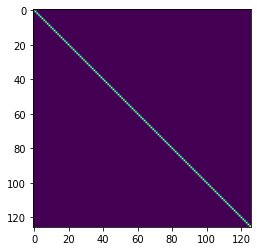

In [9]:
# initialization is close to (proprotional to) identity
h = cyjax.ml.cholesky_from_param(h_params)
plt.imshow(jnp.abs(h))
plt.show()

## Loss function
For convenience, sampling is integrated into the loss function here.
First, we define a loss for a fixed moduli value.
Then, we define a batched loss which considers multiple moduli values per step.

In [10]:
def eta_loss(key, psi, h_param, sample_size):
    """Compute variance-based eta loss."""
    # create sample for MC integral
    (zs, patch), weights = dwork.sample_intersect(
        key, psi, sample_size, weights=True, affine=True)
    
    h = cyjax.ml.cholesky_from_param(h_param)

    etas = metric.eta(h, zs, psi, patch).real
    eta_mean = jnp.mean(weights * jax.lax.stop_gradient(etas)) / jnp.mean(weights)

    loss = (etas / eta_mean - 1) ** 2
    loss *= weights
    loss = jnp.mean(loss)
    
    # if g is not pos. def. eta may be negative -> penalty
    loss += jnp.mean(jnp.log(jnp.where(etas < 0, etas, 0)**2 + 1))

    return loss

In [11]:
# sample multiple values for psi & call model
def loss_function(params, key, sample_size=500, psi_rad=10, batches=4):
    key, k1 = jax.random.split(key)
    psis = cyjax.random.uniform_angle(k1, (batches, 1), 0, psi_rad)
    h_params = model.apply(params, psis)
    loss = jax.vmap(eta_loss, (0, 0, 0, None))(
        jax.random.split(key, batches),
        psis,
        h_params,
        sample_size)
    return jnp.mean(loss)

In [12]:
loss_function(params, next(rns))

DeviceArray(1.89593702, dtype=float64)

## Evaluating the accuracy
The output of the loss function is effectively an average measure (randomly chosen) over the parameter range.
We can gain sligthly more insight by evaluating the accuracy over a fixed range of parameters.
To make evaluation easy, we then show the loss in relation to $|\psi|$ together with the max/min obtained for different complex angles.

In [13]:
# choose a range for |psi|
psi_rad = 100

In [14]:
# 10 radii & 10 complex angles
psi_radii = jnp.linspace(1e-5, psi_rad, 10)
psi_eval = jnp.exp(1j * jnp.arange(0, 2*jnp.pi, jnp.pi/5)) * psi_radii[:, None]
psi_eval = psi_eval.reshape(-1, 1)

In [15]:
@jax.jit
def _accuracies(key, h_par, psi):
    h = cyjax.ml.cholesky_from_param(h_par)
    psi = jnp.atleast_1d(psi)
    return metric.sigma_accuracy(key, psi, h, 1000)

@jax.jit
def eval_accuracy(key, params):
    sig = jax.vmap(_accuracies, (None, 0, 0))(
        key, model.apply(params, psi_eval), psi_eval)
    sig = sig.reshape(10, 10)
    mean = jnp.mean(sig, 1)
    smin = jnp.max(sig, 1)
    smax = jnp.min(sig, 1)
    return mean, smin, smax

In [16]:
smean, smin, smax = eval_accuracy(next(rns), params)

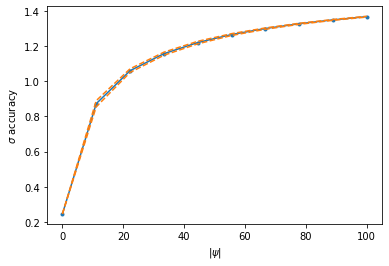

In [17]:
plt.plot(psi_radii, smean, '.-', color='C0')
plt.plot(psi_radii, smin, '--', color='C1')
plt.plot(psi_radii, smax, '--', color='C1')
plt.xlabel(r'$|\psi|$')
plt.ylabel('$\sigma$ accuracy')
plt.show()

## Training

Note: The example here is for illustrative purposes and is meant to run fast rather than give optimal results.

In [18]:
from tqdm import tqdm

In [19]:
opt = optax.adam(1e-3)
opt_state = opt.init(params)

In [20]:
@jax.jit
def update_step(key, params, opt_state):
    grads = jax.grad(loss_function)(params, key)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

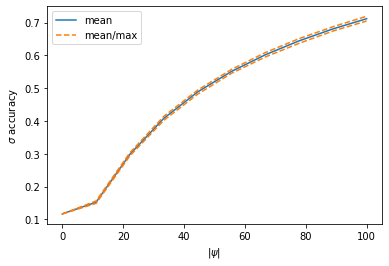

100%|█████████████████████████████████████████████████████████| 200/200 [00:34<00:00,  5.72it/s]


In [21]:
n_steps = 200
plot_every = 100

# plotting of accuracies to monitor training
fig = plt.figure()
ax = plt.gca()
acc_line, = plt.plot(psi_radii, smean, label='mean')
min_line, = plt.plot(psi_radii, smin, '--', color='C1', label='mean/max')
max_line, = plt.plot(psi_radii, smax, '--', color='C1')
plt.legend()
plt.xlabel(r'$|\psi|$')
plt.ylabel('$\sigma$ accuracy')
display_id = display(fig, display_id=True)
display_id.update(fig)


for i in tqdm(range(n_steps)):
    params, opt_state = update_step(next(rns), params, opt_state)
    
    if (i + 1) % plot_every == 0:
        smean, smin, smax = eval_accuracy(next(rns), params)
        acc_line.set_ydata(smean)
        min_line.set_ydata(smin)
        max_line.set_ydata(smax)
        ax.relim()
        ax.autoscale_view()
        display_id.update(fig)

plt.close()